In [1]:
import os
# import os.path
# from os import path

import numpy as np
import matplotlib.pyplot as plt
import pydicom
import csv

from PIL import Image

import keras
from keras.models import Model, Input, load_model
from keras.layers import Input
from keras.layers.core import Dropout #, Lambda
from keras.layers.convolutional import Conv2D, Conv2DTranspose
from keras.layers.pooling import MaxPooling2D
from keras.layers.merge import concatenate
from keras.optimizers import Adam #, SGD
from keras.callbacks import EarlyStopping, ModelCheckpoint
from keras.callbacks import *

import tensorflow as tf

## I think that this should be enough for most people...
#session = tf.Session()

## ... but my Windows machine needs this to run
from tensorflow.compat.v1 import ConfigProto
from tensorflow.compat.v1 import InteractiveSession
config = ConfigProto()
config.gpu_options.allow_growth = True
session = tf.Session(config=config)

Using TensorFlow backend.


In [2]:
# Simple confirmation function
def confirm(question):
    reply = str(input(question + " (y/n): ")).lower().strip()
    if reply[0] == "y":
        return True
    if reply[0] == "n":
        return False
    else:
        return confirm("Choices are ")
    
# Dice
smooth = 1.

def dice_coef(y_true, y_pred):
    y_true_f = K.flatten(y_true)
    y_pred_f = K.flatten(y_pred)
    intersection = K.sum(y_true_f * y_pred_f)
    return (2. * intersection + smooth) / (K.sum(y_true_f) + K.sum(y_pred_f) + smooth)

def dice_coef_loss(y_true, y_pred):
    return -dice_coef(y_true, y_pred)

In [3]:
# Original uncropped image dimensions
ORIGINAL_IMG_HEIGHT = 1024
ORIGINAL_IMG_WIDTH = 1024

# Resized uncropped image dimensions for training
IMG_HEIGHT = 96
IMG_WIDTH = 96

# Number of training set images to use for validation
VAL_SIZE = 20

In [4]:
# Populate training and testing sets
train_X = []
train_Y = []

with open("training_images.csv") as csv_file:
    csv_reader = csv.reader(csv_file, delimiter=',')

    for row in csv_reader:
        # Load Images
        image = Image.open("uncropped_train_images/" + row[0] + ".png", "r")
        mask = Image.open("uncropped_train_masks/" + row[0] + "_mask.png", "r")

        image_pixelarray = np.array(list(image.getdata(0)))
        image_pixelarray = np.reshape(image_pixelarray, (ORIGINAL_IMG_WIDTH,ORIGINAL_IMG_HEIGHT))
        image_pixelarray = np.array(Image.fromarray(image_pixelarray).resize((IMG_WIDTH, IMG_HEIGHT)))
        train_X.append(image_pixelarray)

        mask_pixelarray = np.array(list(mask.getdata(0)))
        mask_pixelarray = np.reshape(mask_pixelarray, (ORIGINAL_IMG_WIDTH,ORIGINAL_IMG_HEIGHT))            
        mask_pixelarray = np.array(Image.fromarray(mask_pixelarray).resize((IMG_WIDTH, IMG_HEIGHT)))
        train_Y.append(mask_pixelarray)

train_X = np.array(train_X)
train_Y = np.array(train_Y)
print("train_X_shape : ", train_X.shape)
print("train_Y_shape : ", train_Y.shape)

train_X_shape :  (197, 96, 96)
train_Y_shape :  (197, 96, 96)


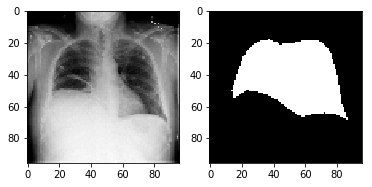

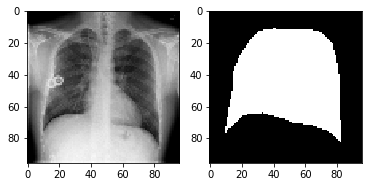

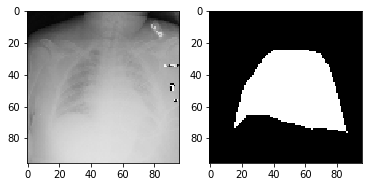

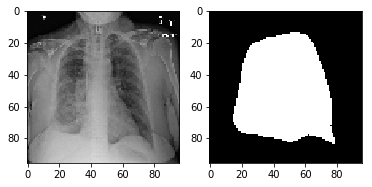

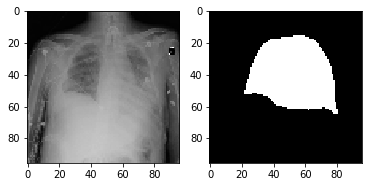

In [5]:
# Show a few uncropped images with their masks
for i in range(5):
    figure, ax = plt.subplots(1,2)
    ax[0].imshow(train_X[i], cmap="gray")
    ax[1].imshow(train_Y[i], cmap="gray")
    plt.show()   

In [6]:
# Divide into training & validation, without shuffling

X = train_X[:len(train_X)-VAL_SIZE]
Y = train_Y[:len(train_Y)-VAL_SIZE]
val_X = train_X[len(train_X)-VAL_SIZE:]
val_Y = train_Y[len(train_Y)-VAL_SIZE:]

X = X[:,:,:,np.newaxis] / 255
Y = Y[:,:,:,np.newaxis] / 255
print("X shape : ", X.shape)
print("Y shape : ", Y.shape)

val_X = val_X[:,:,:,np.newaxis] / 255
val_Y = val_Y[:,:,:,np.newaxis] / 255
print("val_X shape : ", val_X.shape)
print("val_Y shape : ", val_Y.shape)

X shape :  (177, 96, 96, 1)
Y shape :  (177, 96, 96, 1)
val_X shape :  (20, 96, 96, 1)
val_Y shape :  (20, 96, 96, 1)


In [7]:
#Unet model

inputs = Input((IMG_HEIGHT, IMG_WIDTH, 1))

conv1 = Conv2D(32, (3, 3), activation='relu', padding='same')(inputs)
conv1 = Conv2D(32, (3, 3), activation='relu', padding='same')(conv1)
pool1 = MaxPooling2D(pool_size=(2, 2))(conv1)

conv2 = Conv2D(64, (3, 3), activation='relu', padding='same')(pool1)
conv2 = Conv2D(64,(3, 3), activation='relu', padding='same')(conv2)
pool2 = MaxPooling2D(pool_size=(2, 2))(conv2)

conv3 = Conv2D(128, (3, 3), activation='relu', padding='same')(pool2)
conv3 = Conv2D(128, (3, 3), activation='relu', padding='same')(conv3)
pool3 = MaxPooling2D(pool_size=(2, 2))(conv3)

# Skipped (4)

conv5 = Conv2D(256, (3, 3), activation='relu', padding='same')(pool3)
conv5 = Dropout(0.2)(conv5)
conv5 = Conv2D(256, (3, 3), activation='relu', padding='same')(conv5)

# Skipped (6)

up7 = concatenate([Conv2DTranspose(64, (2, 2), strides=(2, 2), padding='same')(conv5), conv3], axis=3)
conv7 = Conv2D(128, (3, 3), activation='relu', padding='same')(up7)
conv7 = Conv2D(128, (3, 3), activation='relu', padding='same')(conv7)

up8 = concatenate([Conv2DTranspose(32, (2, 2), strides=(2, 2), padding='same')(conv7), conv2], axis=3)
conv8 = Conv2D(64, (3, 3), activation='relu', padding='same')(up8)
conv8 = Conv2D(64, (3, 3), activation='relu', padding='same')(conv8)

up9 = concatenate([Conv2DTranspose(16, (2, 2), strides=(2, 2), padding='same')(conv8), conv1], axis=3)
conv9 = Conv2D(32, (3, 3), activation='relu', padding='same')(up9)
conv9 = Conv2D(32, (3, 3), activation='relu', padding='same')(conv9)

conv10 = Conv2D(1, (1, 1), activation='sigmoid')(conv9)

model = Model(inputs=[inputs], outputs=[conv10])
model.compile(optimizer=Adam(lr = 1e-5), loss=dice_coef_loss, metrics=[dice_coef]) #(lr = 1e-5)

Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.


In [8]:
# Set filename to save best model
bestmodelh5 = 'model/bestmodel.h5'

In [9]:
# Initialize the number of epochs and batch size
EPOCHS = 40
BS = 2

# Construct the training image generator
aug = keras.preprocessing.image.ImageDataGenerator() # No augmentation applied

# Set callback functions to early stop training and save the best model so far
callbacks = [
    EarlyStopping(monitor='val_loss', patience=150, verbose=2),
    ModelCheckpoint(filepath=bestmodelh5, monitor='val_loss', 
                    save_best_only=True, verbose=2)   
]

# Check for previously trained weights to avoid accidental overwrite
good_to_go = False
if (os.path.exists(bestmodelh5)) :
    if (confirm('Overwrite previous h5')):
        good_to_go = True
else :
    good_to_go = True

# Do training
if (good_to_go):        
    results = model.fit_generator(
                aug.flow(X, Y, batch_size=BS),
                validation_data=(val_X, val_Y),
                epochs=EPOCHS,
                callbacks=callbacks,
                verbose=1,
                steps_per_epoch=len(X) // BS,
                use_multiprocessing=False, 
                workers=1) 

Epoch 1/40
88/88 [==============================] - 4s 43ms/step - loss: -0.4159 - dice_coef: 0.4159 - val_loss: -0.4020 - val_dice_coef: 0.4020

Epoch 00001: val_loss improved from inf to -0.40199, saving model to model/bestmodel.h5
Epoch 2/40
88/88 [==============================] - 1s 15ms/step - loss: -0.4274 - dice_coef: 0.4274 - val_loss: -0.4394 - val_dice_coef: 0.4394

Epoch 00002: val_loss improved from -0.40199 to -0.43938, saving model to model/bestmodel.h5
Epoch 3/40
88/88 [==============================] - 1s 13ms/step - loss: -0.5247 - dice_coef: 0.5247 - val_loss: -0.5177 - val_dice_coef: 0.5177

Epoch 00003: val_loss improved from -0.43938 to -0.51769, saving model to model/bestmodel.h5
Epoch 4/40
88/88 [==============================] - 1s 13ms/step - loss: -0.5575 - dice_coef: 0.5575 - val_loss: -0.5655 - val_dice_coef: 0.5655

Epoch 00004: val_loss improved from -0.51769 to -0.56551, saving model to model/bestmodel.h5
Epoch 5/40
88/88 [==============================]


Epoch 00038: val_loss did not improve from -0.84561
Epoch 39/40
88/88 [==============================] - 1s 13ms/step - loss: -0.8586 - dice_coef: 0.8586 - val_loss: -0.8451 - val_dice_coef: 0.8451

Epoch 00039: val_loss did not improve from -0.84561
Epoch 40/40
88/88 [==============================] - 1s 13ms/step - loss: -0.8509 - dice_coef: 0.8509 - val_loss: -0.8453 - val_dice_coef: 0.8453

Epoch 00040: val_loss did not improve from -0.84561


dict_keys(['val_loss', 'val_dice_coef', 'loss', 'dice_coef'])


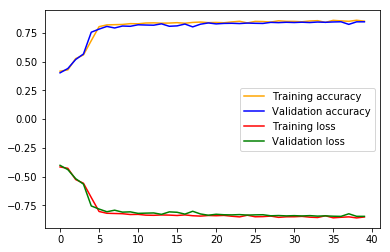

In [10]:
# Display Dice accuracy and losses
print(results.history.keys())

plt.figure()
plt.plot(results.history['dice_coef'], 'orange', label='Training accuracy')
plt.plot(results.history['val_dice_coef'], 'blue', label='Validation accuracy')
plt.plot(results.history['loss'], 'red', label='Training loss')
plt.plot(results.history['val_loss'], 'green', label='Validation loss')
plt.legend()
plt.show()

Total testing files: 10


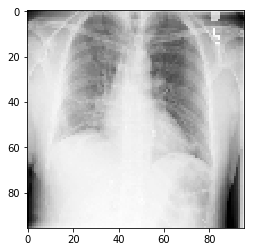

(10, 96, 96, 1)


In [11]:
# FOR DICOM FILES (Cell 1 of 2)
# Run to do crop on DICOM files and output cropped_images and cropped_images_masks

# Get list of training DICOMs

list_of_testing_files = []
list_of_testing_files_location = []

for dirpath, dirnames, files in os.walk('uncropped_test_dicom'):
    for name in files:
        list_of_testing_files.append(name)
        list_of_testing_files_location.append(os.path.join(dirpath, name))

print('Total testing files:', (len(list_of_testing_files)))

# Create training data images (train_X)

test_X = []
test_X_filename = []

for f in range(len(list_of_testing_files_location)):
    dataset = pydicom.dcmread(list_of_testing_files_location[f])
    test_image = np.array(Image.fromarray(dataset.pixel_array).resize((IMG_WIDTH, IMG_HEIGHT)))
    test_X.append(test_image)
    test_X_filename.append(list_of_testing_files[f])
    
test_X = np.array(test_X)

# Display one DICOM file
plt.imshow(test_X[0], cmap="gray")
plt.show()

test_X = test_X[:,:,:,np.newaxis] / 255
print(test_X.shape)

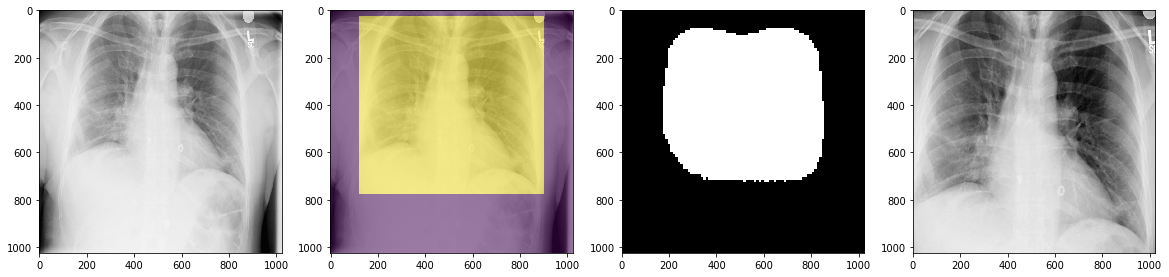

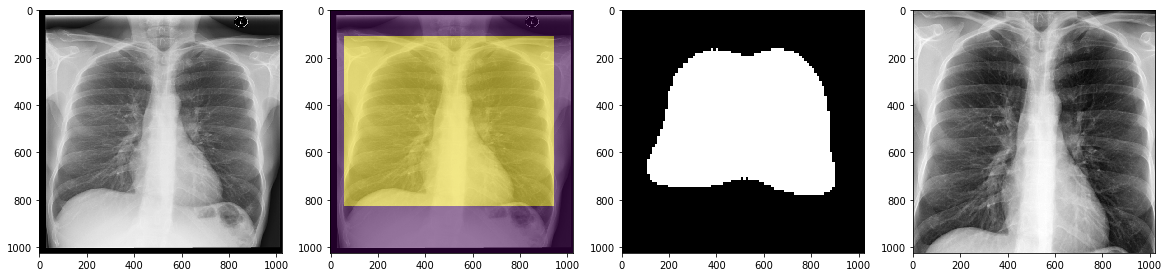

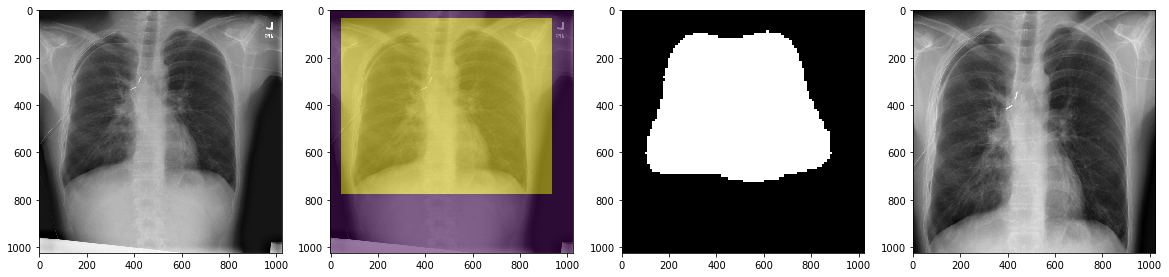

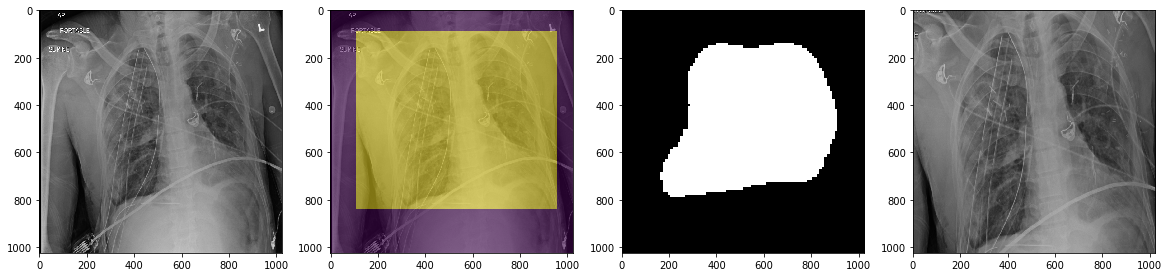

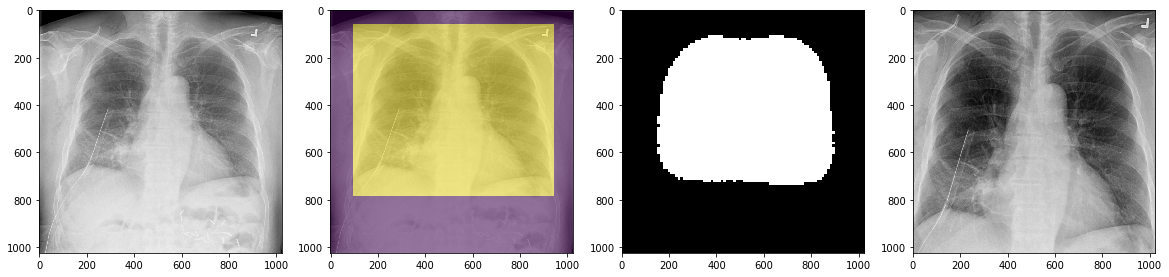

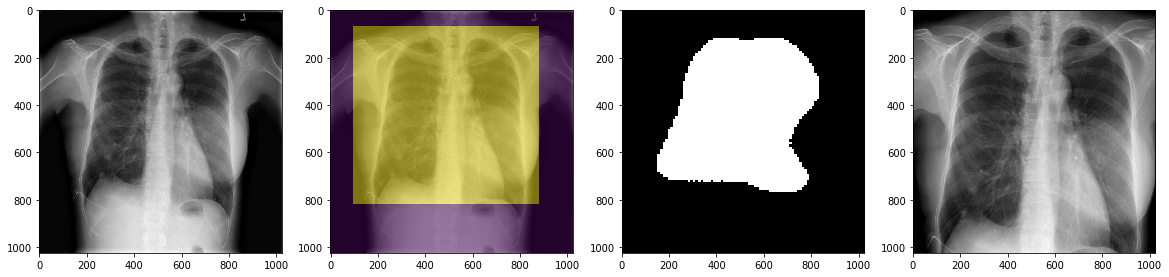

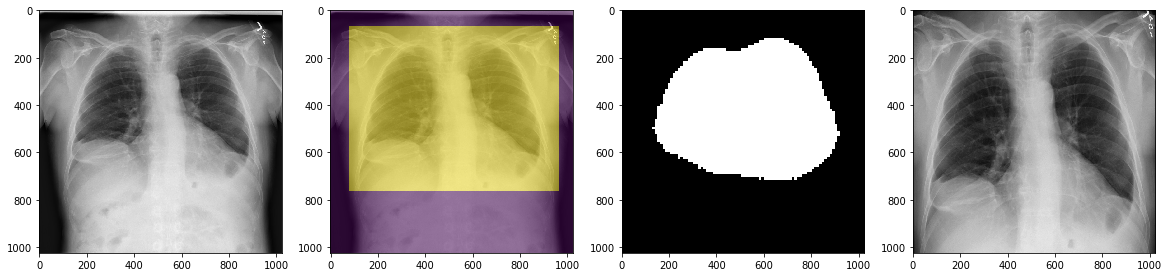

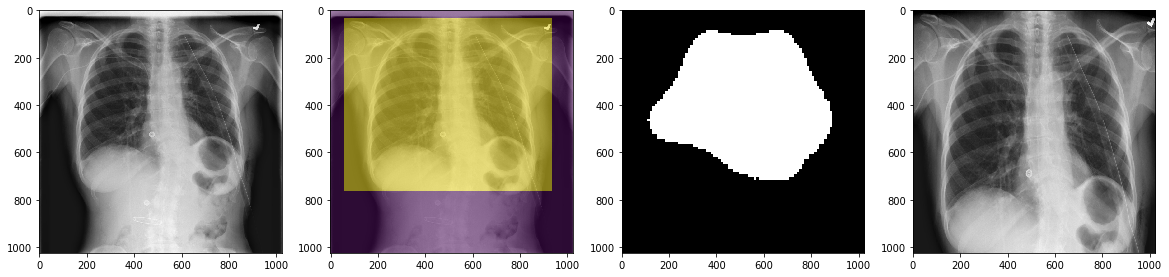

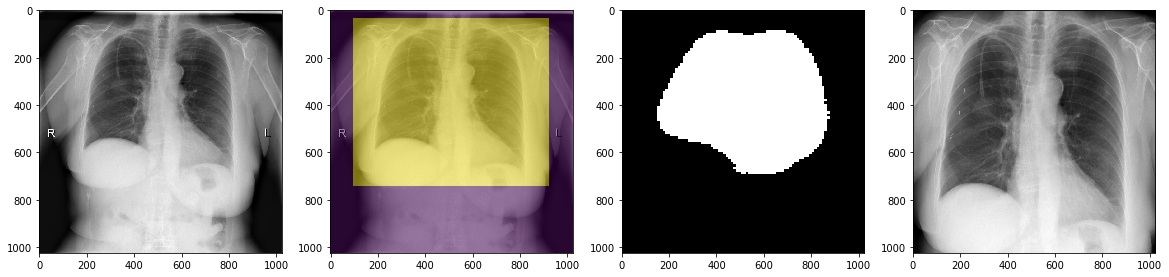

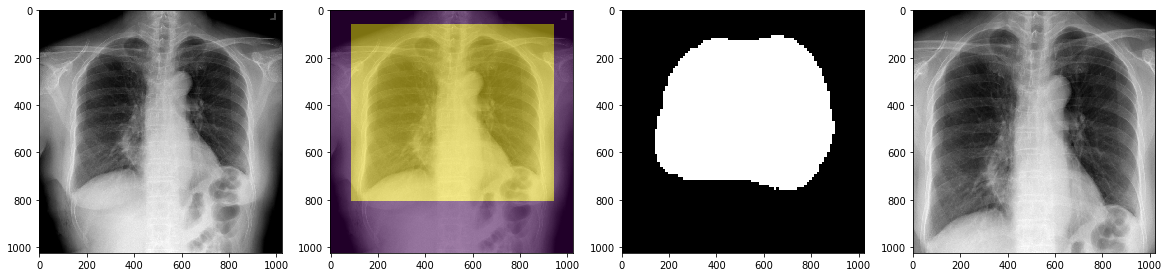

In [12]:
# FOR DICOM FILES (Cell 2 of 2)
# Run to do crop on DICOM files and output cropped_images and cropped_images_masks

# Predict on test set
pred_Y = model.predict(test_X)

# Disable interactive plot
plt.ioff()

# Store crop parameters
# Crop parameters stores the crop dimensions of every test image - so that the results can be "uncropped" later
crop_parameters = []

for i in range(test_X.shape[0]):
    img = pred_Y[i, :, :, 0]
    # Since training was at 96x96, we enlarge the predicted mask to 1024x1024
    img = np.array(Image.fromarray(img).resize((ORIGINAL_IMG_WIDTH, ORIGINAL_IMG_HEIGHT)))   
    # Set the cutoff at 0.5 between True (within mask) and False (outside mask)
    img = img > 0.5
    
    # Get cropping parameters from lung mask 
    segmented = np.where(img[:,]==True)
    
    # padding determines how many pixels outside the predicted mask we want to accept into the final mask
    # As most CXRs have a little bit of chest wall / air around them, we simply choose 50 pixels
    padding = 50
    
    # TODO: Insert catch for small segmentations, maybe <30 pixel count?
    
    try:
        top = np.amin(segmented[0]) - padding
        bottom = np.amax(segmented[0]) + padding
        left = np.amin(segmented[1]) - padding
        right = np.amax(segmented[1]) + padding
    except ValueError:  # Raised if segmented is empty.
        top = 0
        bottom = ORIGINAL_IMG_HEIGHT - 1
        left = 0    
        right = ORIGINAL_IMG_WIDTH - 1 
        
    # Make sure +padding doesn't exceed np array size
    if top < 0:
        top = 0
    if bottom > ORIGINAL_IMG_HEIGHT:
        bottom = ORIGINAL_IMG_HEIGHT - 1
    if left < 0:
        left = 0
    if right > ORIGINAL_IMG_WIDTH:
        right = ORIGINAL_IMG_WIDTH - 1    

    # Create crop_parameter line    
    crop_parameters_row = [test_X_filename[i], top, left, bottom, right]
    crop_parameters.append(crop_parameters_row)
    
    # Lung is a new image that used to display the predicted mask
    lung = np.zeros((ORIGINAL_IMG_WIDTH,ORIGINAL_IMG_HEIGHT))
    lung[:,:] = False
    lung[top:bottom,left:right] = True
    
    # Load the original DICOM into image1
    dataset = pydicom.dcmread("uncropped_test_dicom/" + test_X_filename[i])
    image1 = np.array(Image.fromarray(dataset.pixel_array).resize((ORIGINAL_IMG_WIDTH, ORIGINAL_IMG_HEIGHT)))
    
    # Crop and save PNG
    # Generate and save cropped images
    image2 = image1[top:bottom,left:right] 
    im2 = Image.fromarray(image2)
    im2 = im2.resize((1024,1024),Image.BICUBIC)
    im2.save('cropped_test_images/'+test_X_filename[i]+'_lung.png') 

    # Generate and save original images with masks for result exploration
    fig, ax = plt.subplots(1,3,figsize = (16,12))
    # Original DICOM
    ax[0].imshow(image1, cmap = 'gray')
    # Original DICOM with cropped area (predicted mask + padding)
    ax[1].imshow(image1, cmap = 'gray', interpolation = 'none')
    ax[1].imshow(lung, cmap = 'viridis', interpolation = 'none', alpha = 0.5)
    # Predicted mask
    ax[2].imshow(img, cmap = 'gray')
    fig.savefig('cropped_test_images_masks/'+test_X_filename[i]+'_overlay.png', bbox_inches='tight', dpi=150)
    plt.close(fig)

    # Display within notebook
    fig, ax = plt.subplots(1,4,figsize = (20,12))
    # Original DICOM
    ax[0].imshow(image1, cmap = 'gray')
    # Original DICOM with cropped area (predicted mask + padding)
    ax[1].imshow(image1, cmap = 'gray', interpolation = 'none')
    ax[1].imshow(lung, cmap = 'viridis', interpolation = 'none', alpha = 0.5)
    # Predicted mask
    ax[2].imshow(img, cmap = 'gray')
    ax[3].imshow(im2, cmap = 'gray')
    plt.show()
    plt.close(fig)

# Save crop parameters
np.savetxt("cropped_test_images/crop_parameters.csv", crop_parameters, delimiter=",", fmt='%s')